In [ ]:
# Lab 6 Part 2: Estimating Disturbances

In [68]:
# standard imports

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tclab import setup, Historian, Plotter, clock

In [69]:
# 1. Using the matrix parameters used for Exercise 1 of this assignment, compute and 
# report numerical values for augmented matrices  𝐴𝑎𝑢𝑔 ,  𝐵𝑎𝑢𝑔 ,  𝐶𝑎𝑢𝑔  described above.


# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units

# my device values inserted here
CpH =  8.237             # heat capacity of the heater (J/deg C)
CpS = 1.636              # heat capacity of the sensor (J/deg C)
Ua =  0.0408             # heat transfer coefficient from heater to environment
Ub = 0.0953              # heat transfer coefficient from heater to sensor
Uc = 0.0294              # heat transfer coefficient from heater to sensor
Tamb = 22                # ambient room temperature


# Set up the original state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# Create the augmented matrices
A_ = np.vstack([np.hstack([A, Bd]), np.zeros([1, 5])])
B_ = np.vstack([Bu, [[0, 0]]])
C_ = np.hstack([C, np.zeros([2, 1])])

# Report numerical values for the augmented matrices
print('The augmented matrix Aaug is: \n', A_)
print('The augmented matrix Baug is: \n', B_)
print('The augmented matrix Caug is: \n', C_)

The augmented matrix Aaug is: 
 [[-0.02009227  0.01156975  0.00356926  0.          0.00495326]
 [ 0.05825183 -0.05825183  0.          0.          0.        ]
 [ 0.00356926  0.         -0.02009227  0.01156975  0.00495326]
 [ 0.          0.          0.05825183 -0.05825183  0.        ]
 [ 0.          0.          0.          0.          0.        ]]
The augmented matrix Baug is: 
 [[0.00388491 0.        ]
 [0.         0.        ]
 [0.         0.00194245]
 [0.         0.        ]
 [0.         0.        ]]
The augmented matrix Caug is: 
 [[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [83]:
# Using the results of exercise 1, choose an initial value for  𝐿𝑎𝑢𝑔 . Place four of the eigenvalues to match the eigenvalues placed in exercise 1. 
# The fifth eigenvalue should have a negative value corresponding to a time constant chosen to be between 20 and 100 seconds

# Choose a time constant between 20 and 100 seconds
T_cst = 25 # seconds
# Create a fifth eigenvalue from this time constant
eval_5 = -1/T_cst
print('The fifth eigenvalue is:',round(eval_5,5))

# place the four eigenvalues by having them be multiples of 5 of the eigenvalues of A (from exercise 1)
from scipy.signal import place_poles

evals, evecs = np.linalg.eig(A) 

# add the fifth eigenvalue to calculate for L
results = place_poles(A_.T, C_.T, np.hstack([5*evals, -0.04]))
Laug = results.gain_matrix.T

print('The initial values for the augmented L matrix are: \n',Laug)

The fifth eigenvalue is: -0.04
The initial values for the augmented L matrix are: 
 [[0.22205608 0.11801293]
 [0.33336627 0.02182545]
 [0.11798861 0.22209238]
 [0.0218209  0.33338653]
 [0.62266282 0.62280217]]


In [71]:
# Set up the heater functions

def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

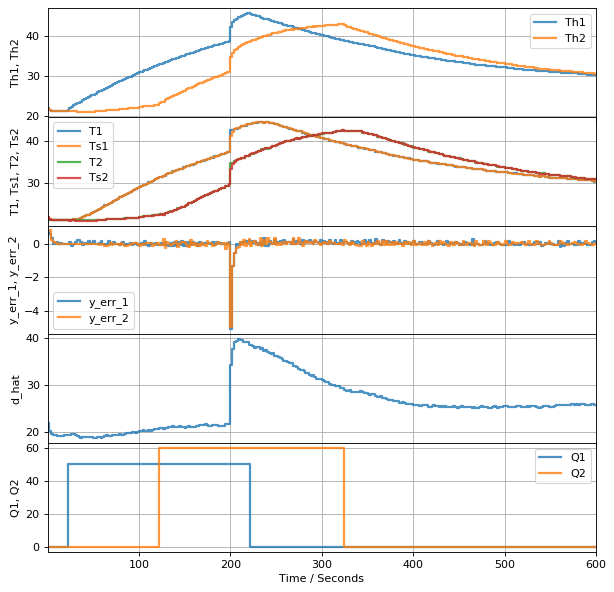

TCLab disconnected successfully.


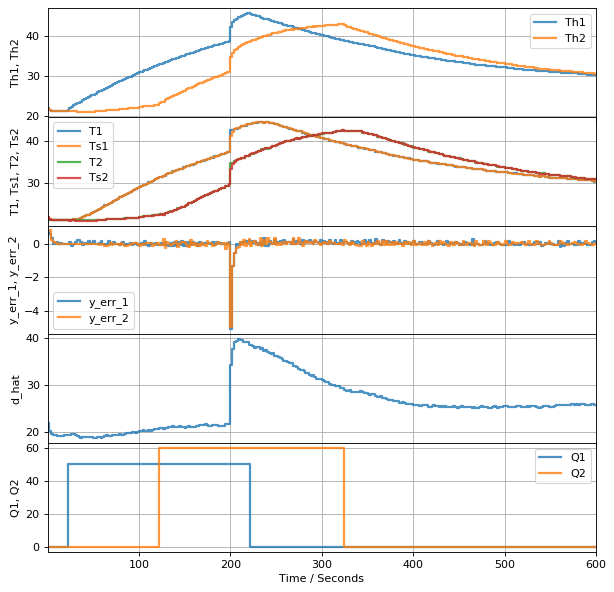

In [74]:
# Part 2. Testing Disturbance Estimator (using the disturbance function d(t))

def tclab_observer_disturbance(L, x_initial, d_hat):
    
    # initialize
    x_hat = np.hstack([x_initial, d_hat])
    print(x_hat)
    t = 0
    y_err = None
    
    A_ = np.vstack([np.hstack([A, Bd]), np.zeros([1, 5])])
    B_ = np.vstack([Bu, [[0, 0]]])
    C_ = np.hstack([C, np.zeros([2, 1])])

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state, wait for message to get
        # t : next time value
        # u : value of manipulated variables from t_prev to t
        # y : measured value of process variables at time t
        t, u, y = yield x_hat, y_err
        
        # model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A_, x_hat) + np.dot(B_, u))
        y_pred = np.dot(C_, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L, y_err)
                       
                       
def experiment_disturbance(observer, u1, u2, t_final=400, t_step=2):
    
    # open connection to tclab
    TCLab = setup(connected=True)
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('d_hat', lambda: x[4]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['d_hat'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1 + d(t), lab.T2 + d(t)]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

def d(t):
    return 0 if t <= 200 else 5

experiment_disturbance(tclab_observer_disturbance(Laug, x_initial, d_initial), u1, u2, t_final=600)

In [ ]:
# Part 3. Test your disturbance estimator on your copy of the Temperature Control Lab. You will need to adapt the testing code presented above for this purpose. 
# Try to detect changes in the environment surrounding your device, such as placing in cooler, warmer, or breezy place.

# Does your disturbance estimator detect the change? If needed, choose a different time constant in part 2.

In [77]:
# Adapt the testing code so that it can detect changes in the environment surrounding the device

def experiment_disturbance_1(observer, u1, u2, t_final=400, t_step=2):
    
    # open connection to tclab
    TCLab = setup(connected=True)
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('d_hat', lambda: x[4]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['d_hat'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1, lab.T2]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h


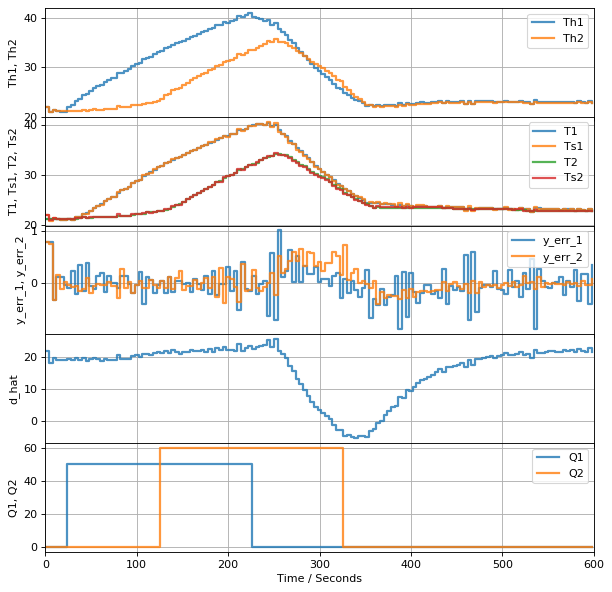

TCLab disconnected successfully.


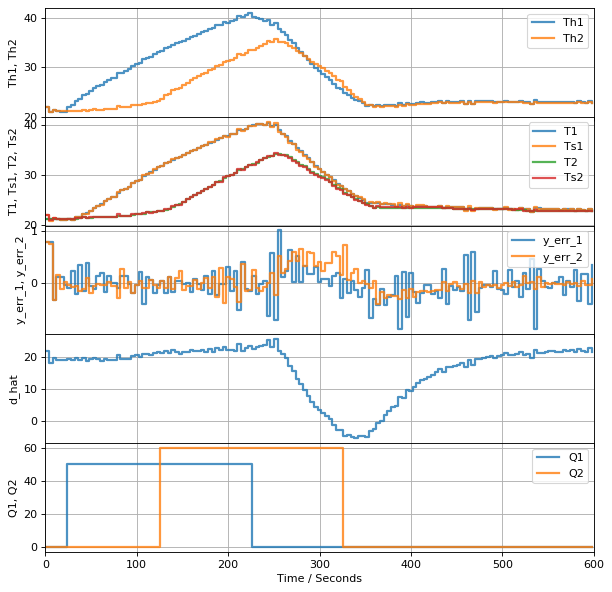

In [78]:
# Experiment 1 - blowing a fan on the device from t=250 seconds to t=350 seconds

experiment_disturbance_1(tclab_observer_disturbance(Laug, x_initial, d_initial), u1, u2, t_final=600)

In [ ]:
# Does your disturbance estimator detect the change?

# The disturbance estimator did detect the change. At approximately 250 seconds, when the fan was turned on, the error had a fluctuation increase
# however the estimator quickly adapted to the change in environment and the estimate of the disturbance decreased to account for the cooler air
# of the fan. This caused the error decrease for the rest of the period when the fan was on. At approximately 350 seconds, when the fan was turned
# off there was another increase in error and the estimator detected the change and responded by increasing the value of the disturbance estimate.

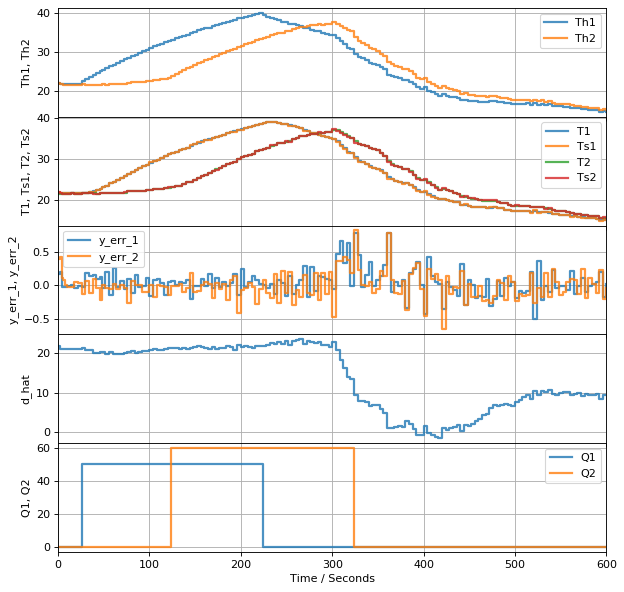

TCLab disconnected successfully.


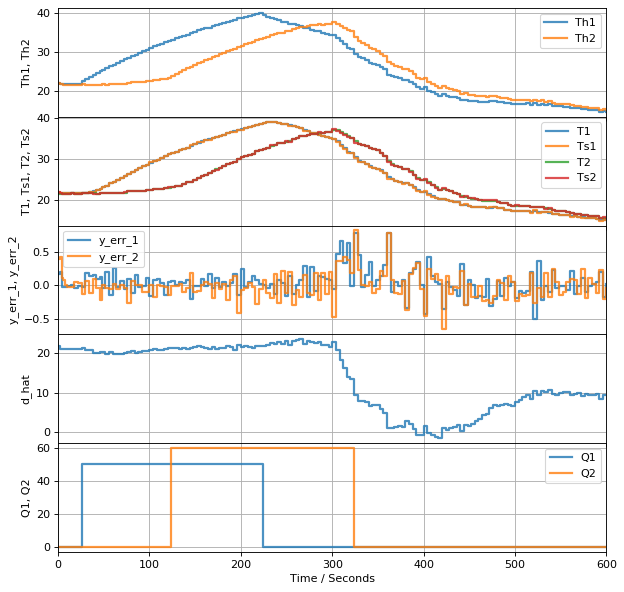

In [79]:
# Experiment 2 - opening a window next to the device from t=300 seconds to t=600 seconds (tfinal)

experiment_disturbance_1(tclab_observer_disturbance(Laug, x_initial, d_initial), u1, u2, t_final=600)

In [ ]:
# Does your disturbance estimator detect the change?

# My disturbance estimator also detected the change for experiment 2 in which I opened a window next to the device to allow a breeze in as a disturbance
# from approximately t=300 seconds to the end of the experiment. When the window opened, the disturbance estimator automatically detected the change.
# There was a a large increase in error as soon as the window was opened and then the disturbance estimate began to decrease to account for the cooler
# breeze temperatures on the sensors. The estimate and the associated error in this case, however, had more fluctuations and did not reach steady values.
# The intermittent breeze gusts from the window caused more error fluctuations because it was not a continuous source of cooler air on the device.

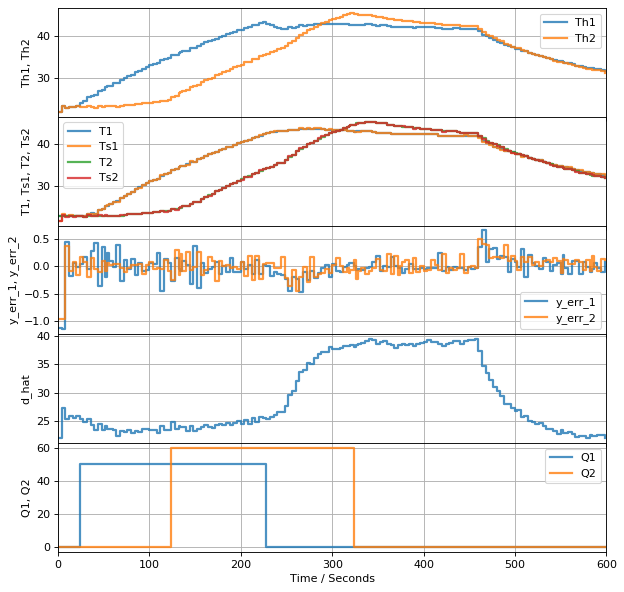

TCLab disconnected successfully.


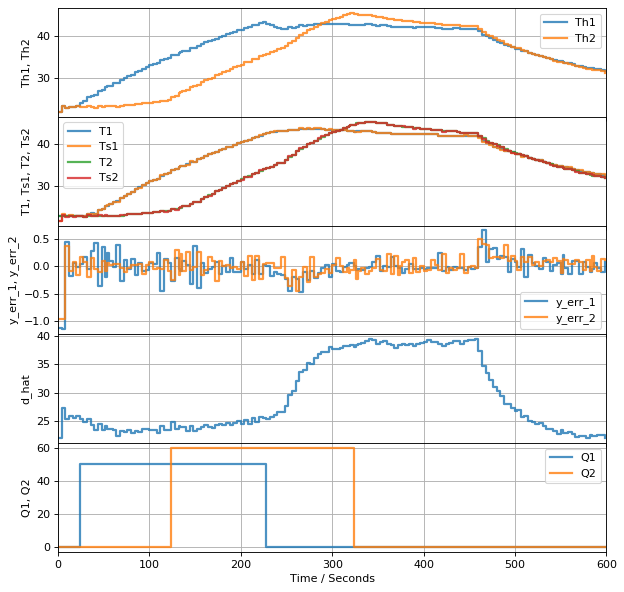

In [82]:
# Experiment 3 - introducing a curling iron next to the device from t=250 seconds to t=450 seconds

experiment_disturbance_1(tclab_observer_disturbance(Laug, x_initial, d_initial), u1, u2, t_final=600)

In [ ]:
# Does your disturbance estimator detect the change?

# My disturbance estimator also detected the change of the addition of a curling iron held closely to the heaters and sensors of the device.
# The curling iron was placed closely to the device for a period of 200 seconds and the estimator reacted by increasing the value of d_hat accordingly
# which eventually reached an almost steady value to account for the heat of the curling iron. The interesting thing about this experiment is that
# the average error that occurred while the curling iron was in place seems to be less than the error of the estimator without the curling iron in place.
# I believe this is due to the fact that the curling iron was in close proximity to the sensors and was held in a  steady position.
# I think it acted somewhat like how one of the heaters on the device would act, causing an increase in the sensor temperatures. One of the larger errors,
# however, did occur when the curling iron was removed from next to the device - this caused a disturbance in which the estimator had to account for the 
# change to a cooler temperature.